In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/kermany2018")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/kermany2018


In [2]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from vit_pytorch import ViT
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 5
TRAIN_DIR = '/kaggle/input/kermany2018/OCT2017 /train'
TEST_DIR = '/kaggle/input/kermany2018/OCT2017 /test'

In [6]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
class_names = train_dataset.classes
num_classes = len(class_names)

# Subsample dataset (e.g., use 50% of data)
train_size = int(0.5 * len(train_dataset))
test_size = int(0.5 * len(test_dataset))
train_indices = range(train_size)
test_indices = range(test_size)
train_dataset = Subset(train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define Vision Transformer model with reduced parameters
model = ViT(
    image_size=IMAGE_SIZE,
    patch_size=16,
    num_classes=num_classes,
    dim=256,
    depth=4,
    heads=4,
    mlp_dim=512,
    dropout=0.1,
    emb_dropout=0.1
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Evaluation on test set
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")


Epoch 1/5 - Testing: 100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


Epoch 1/5 - Train Loss: 0.2696, Train Acc: 0.8996, Test Loss: 0.6656, Test Acc: 0.6983


Epoch 2/5 - Testing: 100%|██████████| 31/31 [00:02<00:00, 10.66it/s]


Epoch 2/5 - Train Loss: 0.1963, Train Acc: 0.9231, Test Loss: 0.7825, Test Acc: 0.6756


Epoch 3/5 - Testing: 100%|██████████| 31/31 [00:02<00:00, 10.87it/s]


Epoch 3/5 - Train Loss: 0.1558, Train Acc: 0.9374, Test Loss: 0.5502, Test Acc: 0.7996


Epoch 4/5 - Testing: 100%|██████████| 31/31 [00:03<00:00,  8.88it/s]


Epoch 4/5 - Train Loss: 0.1288, Train Acc: 0.9500, Test Loss: 0.7539, Test Acc: 0.7438


Epoch 5/5 - Testing: 100%|██████████| 31/31 [00:02<00:00, 10.59it/s]

Epoch 5/5 - Train Loss: 0.1113, Train Acc: 0.9566, Test Loss: 0.4905, Test Acc: 0.8161


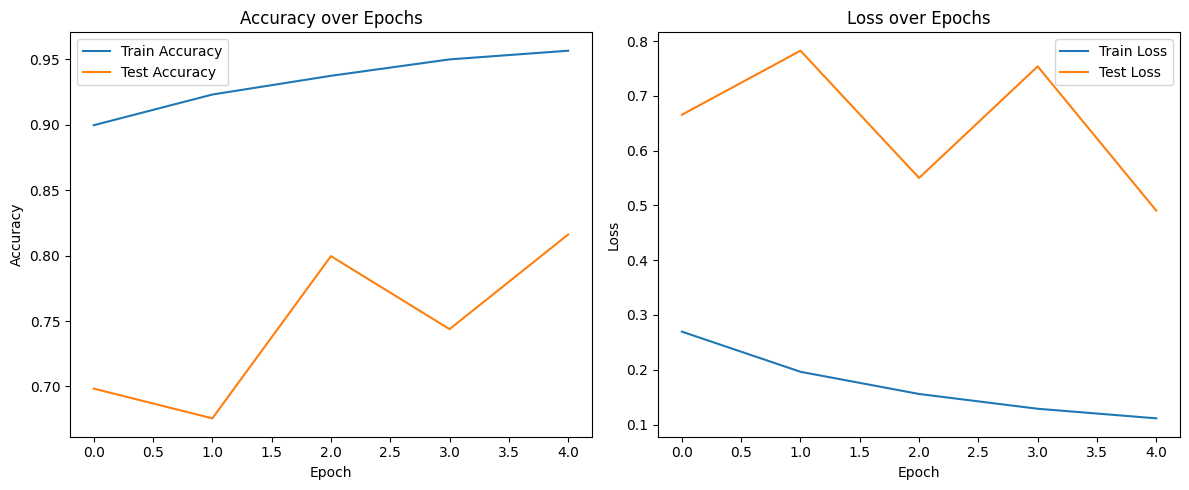

Evaluating on Training set: 100%|██████████| 2609/2609 [04:53<00:00,  8.88it/s]


Training Classification Report:
              precision    recall  f1-score   support

         CNV       0.98      0.99      0.99     37205
         DME       0.93      0.86      0.90      4537

    accuracy                           0.98     41742
   macro avg       0.96      0.93      0.94     41742
weighted avg       0.98      0.98      0.98     41742



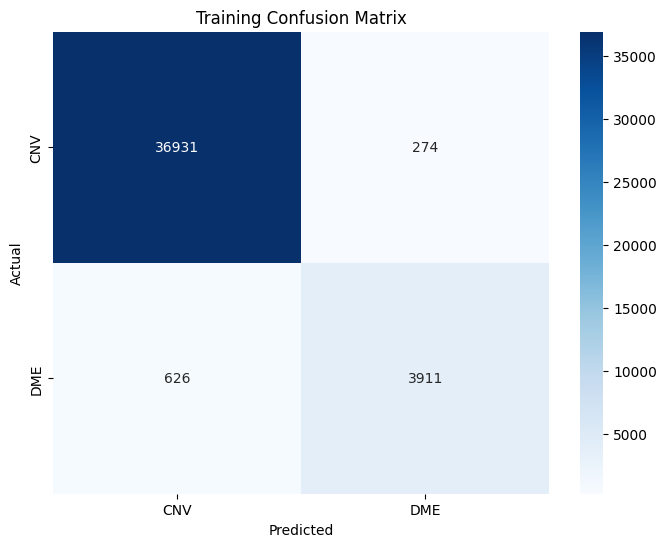

Evaluating on Testing set: 100%|██████████| 31/31 [00:03<00:00,  9.64it/s]

Testing Classification Report:
              precision    recall  f1-score   support

         CNV       0.73      1.00      0.84       242
         DME       1.00      0.63      0.77       242

    accuracy                           0.82       484
   macro avg       0.87      0.82      0.81       484
weighted avg       0.87      0.82      0.81       484



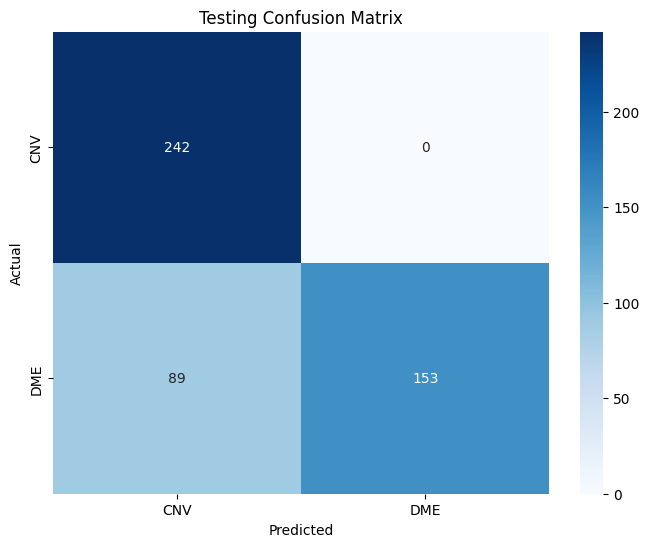

IndexError: index 1 is out of bounds for axis 1 with size 1

In [13]:
# Plot accuracy and loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Function to evaluate model and plot confusion matrix
def evaluate_model(loader, dataset_name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Evaluating on {dataset_name} set"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    # Dynamically get unique classes from labels
    unique_labels = np.unique(all_labels)
    class_names = [train_dataset.dataset.classes[i] for i in unique_labels] if isinstance(train_dataset, Subset) else train_dataset.classes
    print(f"{dataset_name} Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    return all_labels, all_preds

# Evaluate on training and testing sets
train_labels, train_preds = evaluate_model(train_loader, "Training")
test_labels, test_preds = evaluate_model(test_loader, "Testing")

# Compute ROC-AUC for test set
model.eval()
all_probs = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
all_probs = np.array(all_probs)
test_labels_bin = label_binarize(test_labels, classes=range(len(np.unique(test_labels))))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(test_labels))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10,8))
for i in range(len(np.unique(test_labels))):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curves (Testing Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()